# IEOR 4575 Reinforcement Learning Project
## Integer Programming - Cutting Plane Problem [Easy Configuration]
---
Submission by : Arunit Maity (am5689)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -a /content/drive/MyDrive/Project_learn2cut/Project_learn2cut/* /content/

In [ ]:
!pip install -i https://pypi.gurobi.com gurobipy

Looking in indexes: https://pypi.gurobi.com
     |████████████████████████████████| 11.5 MB 14.6 MB/s 


In [ ]:
import numpy as np
import gymenv_v2
from gymenv_v2 import make_multiple_env
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from time import time
import matplotlib.pyplot as plt

In [ ]:
hard_config = {
    "load_dir"        : 'instances/train_100_n60_m60',
    "idx_list"        : list(range(99)),
    "timelimit"       : 50,
    "reward_type"     : 'obj'
}

In [ ]:
# Define Helper Functions
def min_max_scaler(A, b, D, d):
    constraints = np.concatenate((A, D), axis=0)
    rhs = np.concatenate((b, d))
    max_1, max_2 = np.max(constraints), np.max(rhs)
    min_1, min_2 = np.min(constraints), np.min(rhs)
    norm_A = (A - min_1) / (max_1 - min_1)
    norm_D = (D - min_1) / (max_1 - min_1)
    norm_b = (b - min_2) / (max_2 - min_2)
    norm_d = (d - min_2) / (max_2 - min_2)
    return norm_A, norm_b, norm_D, norm_d

def discounted_rewards(r, gamma):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_sum = 0
    for i in reversed(range(0,len(r))):
        discounted_r[i] = running_sum * gamma + r[i]
        running_sum = discounted_r[i]
    return list(discounted_r)

In [ ]:
# Define LSTM Layer
class lstm_layer(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False):
        super(lstm_layer, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=bidirectional, batch_first=True)

    def forward(self, input):
        inputs = torch.FloatTensor(input).view(1, -1, self.input_size)
        output, _ = self.lstm(inputs)
        output = output[-1].reshape(-1, self.hidden_size)
        return output

In [ ]:
# Define Long Short-Term Memory (LSTM) Neural Network with Attention for Q-Value prediction
class lstm_attention_net(nn.Module):
    def __init__(self, input_size, hidden_size_lstm, hidden_size_dense):
        super(lstm_attention_net, self).__init__()
        self.input_size = input_size
        self.hidden_size_lstm = hidden_size_lstm
        self.hidden_size_dense = hidden_size_dense
        self.lstm_A = lstm_layer(input_size, hidden_size_lstm)
        self.lstm_D = lstm_layer(input_size, hidden_size_lstm)
        self.linear_1 = nn.Linear(self.hidden_size_lstm, self.hidden_size_dense)
        self.sigmoid = nn.Sigmoid()

    def forward(self, constraints, cuts):
        constraints = torch.FloatTensor(constraints)
        cuts = torch.FloatTensor(cuts)
        lstm_op_A = self.lstm_A.forward(constraints)
        lstm_op_D = self.lstm_D.forward(cuts)
        A = self.sigmoid(self.linear_1(lstm_op_A))
        D = self.sigmoid(self.linear_1(lstm_op_D))
        attention = torch.sum(torch.mm(D, A.T), axis = -1)
        return attention

In [ ]:
# Define Policy and required functions 
class Policy(object):
    def __init__(self, input_size, hidden_size_lstm, hidden_size_dense, lr):
        self.model = lstm_attention_net(input_size, hidden_size_lstm, hidden_size_dense)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def compute_prob(self, constraints, cuts):
        constraints = torch.FloatTensor(constraints)
        cuts = torch.FloatTensor(cuts)
        prob = torch.nn.functional.softmax(self.model(constraints, cuts), dim=-1)
        return prob.cpu().data.numpy()

    def _to_one_hot(self, y, num_classes):
        scatter_dim = len(y.size())
        y_tensor = y.view(*y.size(), -1)
        zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
        return zeros.scatter(scatter_dim, y_tensor, 1)

    def train(self, constraints, cuts, actions, Qs):
        actions = torch.LongTensor(actions)
        Qs = torch.FloatTensor(Qs)
        total_loss = 0
        
        # Iterate over all constraints and cuts
        for i in range(len(constraints)):
            curr_constraints = constraints[i]
            curr_cuts = cuts[i]
            curr_action = actions[i]
            # Compute probabilities for actions 
            logits = self.model(curr_constraints, curr_cuts)
            prob = torch.nn.functional.softmax(logits, dim = -1)
            action_onehot = self._to_one_hot(curr_action, curr_cuts.shape[0])
            prob_selected = torch.sum(prob * action_onehot, axis = -1)
            prob_selected += 1e-8  # To avoid log(0) (in case prob = 0)
            loss = -torch.mean(Qs[i] * torch.log(prob_selected))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.detach().cpu().data.numpy()
        return total_loss

In [ ]:
# Setup Environment, Actor and Inital Variable Values
env = make_multiple_env(**hard_config) 
lr = 1e-3
gamma = 0.98
input_dim = 61
lstm_hidden = 256
dense_hidden = 256
actor = Policy(input_size=input_dim, hidden_size_lstm=lstm_hidden, hidden_size_dense=dense_hidden, lr=lr)
rrecord = []
loss_record = []
reward_record = []
moving_average = []

loading training instances, dir instances/train_100_n60_m60 idx 0
loading training instances, dir instances/train_100_n60_m60 idx 1
loading training instances, dir instances/train_100_n60_m60 idx 2
loading training instances, dir instances/train_100_n60_m60 idx 3
loading training instances, dir instances/train_100_n60_m60 idx 4
loading training instances, dir instances/train_100_n60_m60 idx 5
loading training instances, dir instances/train_100_n60_m60 idx 6
loading training instances, dir instances/train_100_n60_m60 idx 7
loading training instances, dir instances/train_100_n60_m60 idx 8
loading training instances, dir instances/train_100_n60_m60 idx 9
loading training instances, dir instances/train_100_n60_m60 idx 10
loading training instances, dir instances/train_100_n60_m60 idx 11
loading training instances, dir instances/train_100_n60_m60 idx 12
loading training instances, dir instances/train_100_n60_m60 idx 13
loading training instances, dir instances/train_100_n60_m60 idx 14
loadi

In [ ]:
# Main (Hard) [Training for 100 episodes] 

tic = time()
for e in range(100):
  tic_e = time()
  s = env.reset()
  d = False
  t = 0
  repisode = 0
  obs_constraints = []
  obs_cuts = []
  acts = []
  rews = []
  epsilon = np.max([np.exp(-0.05*e), 0.1])

  while not d:
    A, b, c, D, d = s
    A, b, D, d = min_max_scaler(A, b, D, d)
    # Aggregate RHS and LHS in the same matrix through concatenation
    avail_constraints = np.concatenate((A, b[:, None]), axis=1)
    gomory_cuts = np.concatenate((D, d[:, None]), axis=1)
    # Use ANN Model to compute probabilities for each action
    prob = actor.compute_prob(avail_constraints, gomory_cuts)
    prob /= np.sum(prob)
    # Epsilon Greedy Exploration
    result = np.random.rand(1)
    if result < epsilon:
      a = np.random.randint(0, s[-1].size, 1)
    else:
      a = [np.random.choice(s[-1].size,  p=prob.flatten())]
    # Take action and get new state, reward and done status
    s, r, d, _ = env.step(list(a))
    obs_constraints.append(avail_constraints)
    obs_cuts.append(gomory_cuts)
    acts.append(a)
    rews.append(r)
    repisode += r
  
  rrecord.append(repisode)
  rewards = discounted_rewards(rews, gamma)
  loss = actor.train(obs_constraints, obs_cuts, acts, rewards)
  toc_e = time()
  print("Episode: ", e, "| Sum Reward: ", np.round(repisode, 3), "| Loss: ", np.round(loss, 3), "| Elapsed Time: ", np.round(toc_e-tic_e), 'seconds')
  loss_record.append(loss)
  reward_record.append(repisode)
  fixedWindow=10
  movingAverage=0
  if len(rrecord) >= fixedWindow:
    movingAverage=np.mean(rrecord[len(rrecord)-fixedWindow:len(rrecord)-1])
    moving_average.append(movingAverage)
toc = time()

print('Time required for training :', toc-tic)

Episode:  0 | Sum Reward:  0.754 | Loss:  39.08 | Elapsed Time:  41.0 seconds
Episode:  1 | Sum Reward:  0.198 | Loss:  16.78 | Elapsed Time:  48.0 seconds
Episode:  2 | Sum Reward:  0.625 | Loss:  138.245 | Elapsed Time:  40.0 seconds
Episode:  3 | Sum Reward:  1.01 | Loss:  259.999 | Elapsed Time:  43.0 seconds
Episode:  4 | Sum Reward:  0.778 | Loss:  27.779 | Elapsed Time:  44.0 seconds
Episode:  5 | Sum Reward:  0.259 | Loss:  4.688 | Elapsed Time:  45.0 seconds
Episode:  6 | Sum Reward:  0.35 | Loss:  44.522 | Elapsed Time:  35.0 seconds
Episode:  7 | Sum Reward:  0.588 | Loss:  25.07 | Elapsed Time:  40.0 seconds
Episode:  8 | Sum Reward:  0.341 | Loss:  38.626 | Elapsed Time:  34.0 seconds
Episode:  9 | Sum Reward:  0.082 | Loss:  2.75 | Elapsed Time:  33.0 seconds
Episode:  10 | Sum Reward:  1.204 | Loss:  115.643 | Elapsed Time:  42.0 seconds
Episode:  11 | Sum Reward:  0.654 | Loss:  0.002 | Elapsed Time:  36.0 seconds
Episode:  12 | Sum Reward:  1.029 | Loss:  66.252 | Elap

In [ ]:
np.mean(reward_record)

0.6528485811067571

In [ ]:
import matplotlib.pyplot as plt


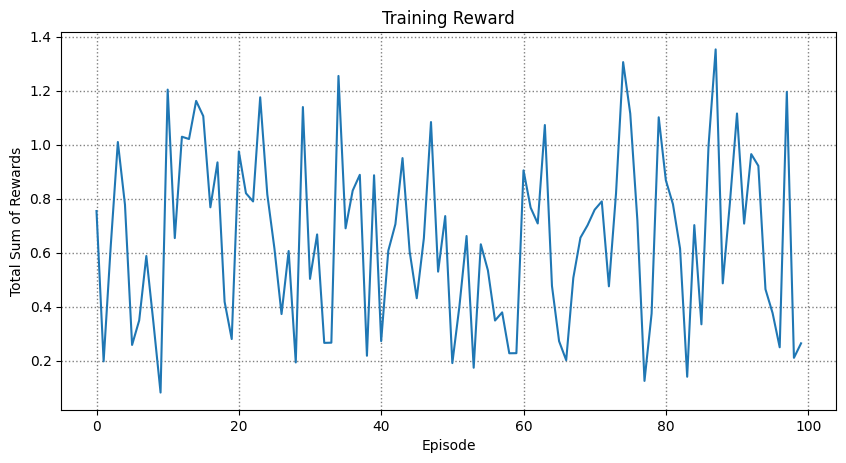

In [ ]:
# Plot Training Reward
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(reward_record)
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Training Reward')
plt.xlabel('Episode')
plt.ylabel('Total Sum of Rewards')
plt.show()

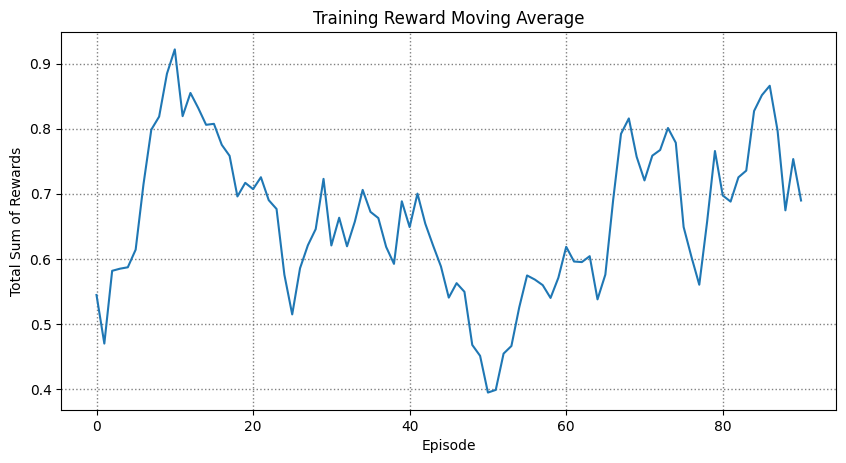

In [ ]:
# Plot Training Reward Moving Average
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(moving_average)
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Training Reward Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Sum of Rewards')
plt.show()

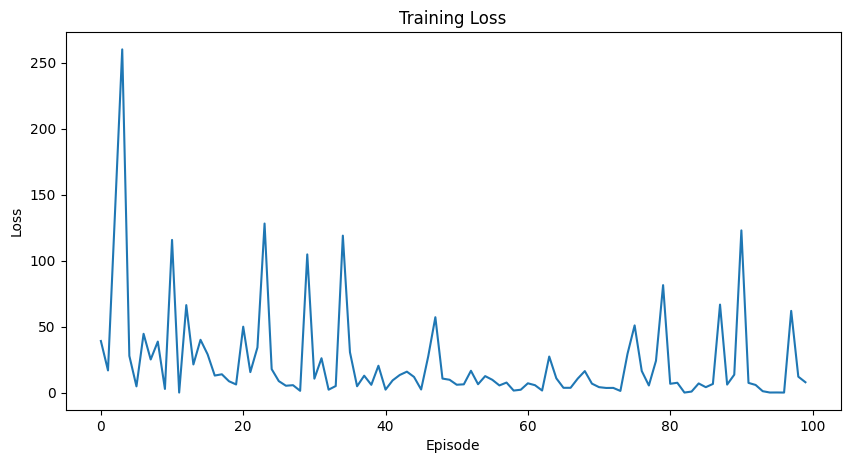

In [ ]:
# Plot Training Loss
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(loss_record)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Create Testing Instances
!python generate_randomip.py --num-v 60 --num-c 60 --num-instances 100

start generating instances
Restricted license - for non-production use only - expires 2023-10-25
num of instances generated: 1
num of instances generated: 2
num of instances generated: 3
num of instances generated: 4
num of instances generated: 5
num of instances generated: 6
num of instances generated: 7
num of instances generated: 8
num of instances generated: 9
num of instances generated: 10
num of instances generated: 11
num of instances generated: 12
num of instances generated: 13
num of instances generated: 14
num of instances generated: 15
num of instances generated: 16
num of instances generated: 17
num of instances generated: 18
num of instances generated: 19
num of instances generated: 20
num of instances generated: 21
num of instances generated: 22
num of instances generated: 23
num of instances generated: 24
num of instances generated: 25
num of instances generated: 26
num of instances generated: 27
num of instances generated: 28
num of instances generated: 29
num of instan

In [31]:
# Main (Hard) [Testing for 100 different instances]
from testgymenv import make_gurobi_env

instance_name = "randomip_n60_m60"
timelimit = 50
tic = time()

for instance_idx in range(100):
  env = make_gurobi_env('instances/{}'.format(instance_name), instance_idx, timelimit)
  s = env.reset()
  d = False
  repisode = 0
  obs_constraints = []
  obs_cuts = []
  acts = []
  rews = []
  tic_e = time()
  while not d:
    A, b, c, D, d = s
    A, b, D, d = min_max_scaler(A, b, D, d)
    # Aggregate RHS and LHS in the same matrix through concatenation
    avail_constraints = np.concatenate((A, b[:, None]), axis=1)
    gomory_cuts = np.concatenate((D, d[:, None]), axis=1)
    # Use ANN Model to compute probabilities for each action
    prob = actor.compute_prob(avail_constraints, gomory_cuts)
    prob /= np.sum(prob)
    a = [np.random.choice(s[-1].size,  p=prob.flatten())]
    s, r, d, _ = env.step(list(a))
    obs_constraints.append(avail_constraints)
    obs_cuts.append(gomory_cuts)
    acts.append(a)
    rews.append(r)
    repisode += r
  rrecord.append(repisode)
  rewards = discounted_rewards(rews, gamma)
  toc_e = time()
  print("Episode: ", instance_idx, "| Sum Reward: ", np.round(repisode, 3), "| Elapsed Time: ", np.round(toc_e-tic_e), 'seconds')
  reward_record.append(repisode)
  fixedWindow=10
  movingAverage=0
  if len(rrecord) >= fixedWindow:
    movingAverage=np.mean(rrecord[len(rrecord)-fixedWindow:len(rrecord)-1])
    moving_average.append(movingAverage)
toc = time()

print('Time required for testing :', toc-tic)

loading training instances, dir instances/randomip_n60_m60 idx 0
Episode:  0 | Sum Reward:  0.698 | Elapsed Time:  35.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 1
Episode:  1 | Sum Reward:  0.171 | Elapsed Time:  27.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 2
Episode:  2 | Sum Reward:  0.08 | Elapsed Time:  26.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 3
Episode:  3 | Sum Reward:  0.435 | Elapsed Time:  28.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 4
Episode:  4 | Sum Reward:  0.073 | Elapsed Time:  26.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 5
Episode:  5 | Sum Reward:  0.387 | Elapsed Time:  26.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 6
Episode:  6 | Sum Reward:  0.149 | Elapsed Time:  26.0 seconds
loading training instances, dir instances/randomip_n60_m60 idx 7
Episode:  7 | Sum Reward:  0.625 | Elaps

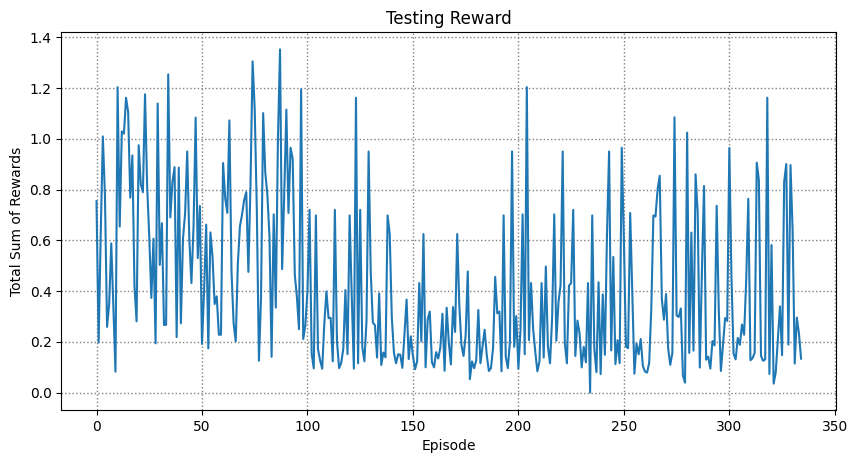

In [32]:
# Plot Testing Reward
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(reward_record)
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Testing Reward')
plt.xlabel('Episode')
plt.ylabel('Total Sum of Rewards')
plt.show()

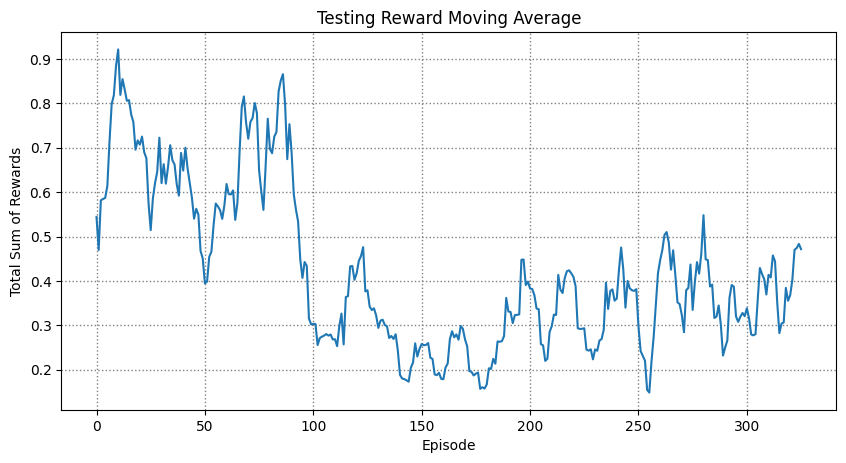

In [33]:
# Plot Testing Reward Moving Average
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(moving_average)
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Testing Reward Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Sum of Rewards')
plt.show()